In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Part 1 - Non-Linear Regression

Generate the data points

In [ ]:
np.random.seed(42)

n = 25
degree = 9

x = np.random.rand(n)  
eps = np.random.uniform(-0.3, 0.3, n)

y = np.sin(5 * np.pi * x) + eps
X = np.column_stack([x**k for k in range(degree + 1)])

X_train, X_test, y_train, y_test, x_train, x_test = train_test_split(
    X, y, x, test_size=0.3, random_state=2)

X_train.shape, X_test.shape

((17, 10), (8, 10))

In [ ]:
lambdas = [0, 0.01, 0.1, 1, 10]
models = {}
y_preds = {}

for lam in lambdas:
    model = Ridge(alpha=lam)
    model.fit(X_train, y_train)
    models[lam] = model

    grid = np.linspace(0, 1, 300)
    X_grid = np.column_stack([grid**k for k in range(X_train.shape[1])])
    y_preds[lam] = model.predict(X_grid)

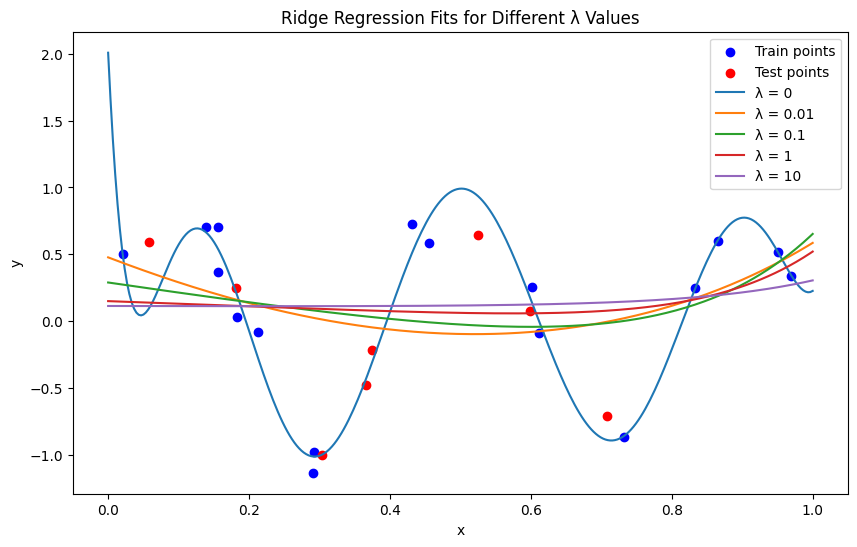

In [40]:
plt.figure(figsize=(10,6))

# Scatter true train and test points
plt.scatter(x_train, y_train, label="Train points", color='blue')
plt.scatter(x_test, y_test, label="Test points", color='red')

grid = np.linspace(0, 1, 300)

for lam in lambdas:
    plt.plot(grid, y_preds[lam], label=f"λ = {lam}")

plt.legend()
plt.title("Ridge Regression Fits for Different λ Values")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
for lam in lambdas:
    model = models[lam]
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    print(f"lambda = {lam:<5}   Test MSE = {mse:.4f}")

lambda = 0       Test MSE = 0.0482
lambda = 0.01    Test MSE = 0.2975
lambda = 0.1     Test MSE = 0.3204
lambda = 1       Test MSE = 0.3477
lambda = 10      Test MSE = 0.3687
